In [1]:
%matplotlib inline
from imp import reload
import pickle

from matplotlib import pyplot as plt
import numpy as np
import torch as th
from torch.utils.data import DataLoader
import ttools

from dps_3d import datasets, utils
from dps_3d.interfaces import VectorizerInterface
from dps_3d.models import PrimsModel

In [2]:
th.manual_seed(123)
th.backends.cudnn.deterministic = True
np.random.seed(123)

In [3]:
data = datasets.ShapenetDataset('data/chairs', 64)
dataloader = DataLoader(data)

In [4]:
model = PrimsModel(output_dim=11*16)
model.eval();

In [5]:
checkpointer = ttools.Checkpointer('output/chairs', model)
checkpointer.load_latest()

({'epoch': 81}, None)

In [13]:
with th.no_grad():
    x = data[3]
    print(x['fname'])
    target_distance_fields = x['distance_fields']
    target_occupancy_fields = x['occupancy_fields']
    params = model(target_distance_fields[None,None])

1013f70851210a618f2e765c4a8ed3d


In [14]:
params = params.view(params.size(0), 16, -1).detach()
params = th.cat([0.3*th.sigmoid(params[...,:3])+0.05,
                 params[...,3:6],
                 0.8*th.sigmoid(params[...,6:10])+0.1,
                 th.sigmoid(params[...,10:])], dim=-1)

In [15]:
distance_fields = utils.compute_distance_fields(params, 64,
                                                df=utils.distance_to_rounded_cuboids).abs()
distance_fields = distance_fields.min(1)[0]
alignment_fields = utils.compute_alignment_fields(distance_fields)
distance_fields = distance_fields[...,1:-1,1:-1,1:-1]
occupancy_fields = utils.compute_occupancy_fields(distance_fields)

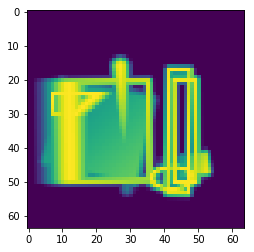

In [16]:
plt.imshow(occupancy_fields[0,:,32].detach())

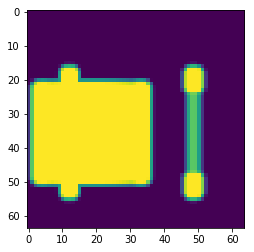

In [17]:
plt.imshow(target_occupancy_fields[:,32].detach())

In [18]:
primitives = []
for p in params[0]:
    b, q, T, r = (x.numpy() for x in th.split(p, [3, 4, 3, 1]))
    q /= np.sqrt(np.sum(q**2))
    primitives.append({
        'translation': T,
        'rotation': q,
        'size': b,
        'r': r
    })

In [19]:
pickle.dump(primitives, open('boxes', 'wb'))